# DM Halo Merger Remnant: Density Profile/Shape (Pre vs Post Merger)

## Goals

This project looks at the density profile and shape of the dark matter halos of MW & M31 before and after they have merged. 
The specific question I'll be answering using this code is: what shape is the halo remnant? Prolate, Oblate or Triaxial.
I will create an isodensity plot from each galaxy at snapshot 0 as well as a final density projection of the remnant. In each plot I'll overplot an ellipse that matches as closely as possible my denisty countour in order to predict the axial ratios of the halo.

In [1]:
# Need to import data from snapshot 0 and last snapshot 
# Need to create a function that rotates the angular momentum vector of my halos so that they are aligned with 
# the postive z-direction (Lab 7)
# Create density countour diagrams from MW & M31 halos and one more for the merger
# Plot an ellipse centered at zero with a given major axis and axis ratios 
# Overplot the ellipse, varying the axis ratio until your ellipse roughly matches a contour. Do this at a few different radii. 
# This gives me the axial ratio so that I can define “prolate, oblate or triaxial” (Slide 5 Lecture 15)
# """Questions:
#         How do I get the data from the last snapshot? How do I combine it into
#         a single object (the remnant) 
# """

### Plot I'm trying to reproduce
![title](./density_sample.png)


In [2]:
# Jimena Stephenson
# with code from R. Hoffman and E. Patel

# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib
from matplotlib import *
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

# my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile
from astropy.modeling.models import Ellipse2D
from astropy.coordinates import Angle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [54]:
# Code for plotting contours
#from https://gist.github.com/adrn/3993992

import scipy.optimize as so

def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
        
    Example Usage
    -------------
     density_contour(x pos, y pos, contour res, contour res, axis, colors for contours)
     e.g.:
     density_contour(xD, yD, 80, 80, ax=ax, colors=['red','orange', 'yellow', 'orange', 'yellow'])

    """

    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y), normed=True)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))
    
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    fmt = {}
    
    ### Adjust Here #### 
    
    # Contour Levels Definitions
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.05))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.18))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.58))
    four_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.70)) 
    five_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))
#     six_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.60))

    # Array of Contour levels. Adjust according to the above
#     levels = [one_sigma, one_sigma1, one_sigma2, two_sigma, three_sigma][::-1]
#     levels = [one_sigma, two_sigma, three_sigma, four_sigma, five_sigma, six_sigma][::-1]
    levels = [one_sigma, two_sigma, three_sigma, four_sigma][::-1]
    
    # contour level labels  Adjust accoding to the above.
    strs = ['0.05', '0.18', '0.58', '0.70', '0.99'][::-1]

    
    ###### 
    
    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        plt.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)

    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        ax.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)
    
    return contour

In [19]:
# Create a COM object for MW & M31 DM Using Code from CenterOfMass
COMMW = CenterOfMass("MW_434.txt",1)
COM31 = CenterOfMass("M31_434.txt",1)

#### CREATE A COM FOR THE MERGER

In [20]:
# Compute COM of MW, M31 and merger using DM particles
COMP_MW = COMMW.COM_P(0.1)
COMV_MW = COMMW.COM_V(COMP_MW[0], COMP_MW[1], COMP_MW[2])

COMP_M31 = COM31.COM_P(0.1)
COMV_M31 = COM31.COM_V(COMP_M31[0], COMP_M31[1], COMP_M31[2])

### COM_P COM_V MERGER

In [21]:
# Determine positions of dm particles relative to COM 

## MW ###
x_mw = COMMW.x - COMP_MW[0].value
y_mw = COMMW.y - COMP_MW[1].value
z_mw = COMMW.z - COMP_MW[2].value

## M31 ###
x_m31 = COM31.x - COMP_M31[0].value
y_m31 = COM31.y - COMP_M31[1].value
z_m31 = COM31.z - COMP_M31[2].value

# ### merger ###

x_merger = np.concatenate([x_mw, x_m31])
y_merger = np.concatenate([y_mw, y_m31])
z_merger = np.concatenate([z_mw, z_m31])



# Magnitude of vector position  

## MW ##
rtot_mw = np.sqrt(x_mw**2 + y_mw**2 + z_mw**2)

## M31 ##
rtot_m31 = np.sqrt(x_m31**2 + y_m31**2 + z_m31**2)

## merger ##
rtot_merger = np.sqrt(x_merger**2 + y_merger**2 + z_merger**2)

###### make radius smaller MW M31

# 20 kpc
index1_mw = np.where(rtot_mw <20)
index1_m31 = np.where(rtot_m31 <20)
index1_merger = np.where(rtot_merger <20)

# 200 kpc
index2_mw = np.where(rtot_mw < 200)
index2_m31 = np.where(rtot_m31 < 200)
index2_merger = np.where(rtot_merger < 200)



##### don't do the rotation yet
# Determine velocities of DM particles for MW, M31 and merger relative to COM

## MW ###
vx_mw = COMMW.vx - COMV_MW[0].value
vy_mw = COMMW.vy - COMV_MW[1].value
vz_mw = COMMW.vz - COMV_MW[2].value

## M31 ### 
vx_m31 = COM31.vx - COMV_M31[0].value
vy_m31 = COM31.vy - COMV_M31[1].value
vz_m31 = COM31.vz - COMV_M31[2].value


vx_merger = np.concatenate([vx_mw, vx_m31])
vy_merger = np.concatenate([vy_mw, vy_m31])
vz_merger = np.concatenate([vz_mw, vz_m31])

# Magnitude of vector velocity

## MW ##
vtot_mw = np.sqrt(vx_mw**2 + vy_mw**2 + vz_mw**2 )
## M31 ##
vtot_m31 = np.sqrt(vx_m31**2 + vy_m31**2 + vz_m31**2 )
## merger ##
vtot_merger = np.sqrt(vx_merger**2 + vy_merger**2 + vz_merger**2 )


# r & v vectors 

## MW ##
r_mw_20 = np.array([x_mw[index1_mw], y_mw[index1_mw], z_mw[index1_mw]]).T 
r_mw_200 = np.array([x_mw[index2_mw], y_mw[index2_mw], z_mw[index2_mw]]).T 
v_mw_20 = np.array([vx_mw[index1_mw], vy_mw[index1_mw], vz_mw[index1_mw]]).T
v_mw_200 = np.array([vx_mw[index2_mw], vy_mw[index2_mw], vz_mw[index2_mw]]).T

## M31 ##
r_m31_20 = np.array([x_m31[index1_m31], y_m31[index1_m31], z_m31[index1_m31]]).T 
r_m31_200 = np.array([x_m31[index2_m31], y_m31[index2_m31], z_m31[index2_m31]]).T 
v_m31_20 = np.array([vx_m31[index1_m31], vy_m31[index1_m31], vz_m31[index1_m31]]).T
v_m31_200 = np.array([vx_m31[index2_m31], vy_m31[index2_m31], vz_m31[index2_m31]]).T

## merger ##
r_merger_20 = np.array([x_merger[index1_merger], y_merger[index1_merger], z_merger[index1_merger]]).T 
r_merger_200 = np.array([x_merger[index2_merger], y_merger[index2_merger], z_merger[index2_merger]]).T 
v_merger_20 = np.array([vx_merger[index1_merger], vy_merger[index1_merger], vz_merger[index1_merger]]).T
v_merger_200 = np.array([vx_merger[index2_merger], vy_merger[index2_merger], vz_merger[index2_merger]]).T

In [22]:
# Rotate the position and velocity vectors so that the DM angular momentum
# is aligned with z+ axis from Lab 7

def RotateFrame(posI,velI):
    # input:  3D array of positions and velocities
    # returns: 3D array of rotated positions and velocities such that j is in z direction

    # compute the angular momentum
    L = np.sum(np.cross(posI,velI), axis=0)
    # normalize the vector
    L_norm = L/np.sqrt(np.sum(L**2))


    # Set up rotation matrix to map L_norm to z unit vector (disk in xy-plane)
    
    # z unit vector
    z_norm = np.array([0, 0, 1])
    
    # cross product between L and z
    vv = np.cross(L_norm, z_norm)
    s = np.sqrt(np.sum(vv**2))
    
    # dot product between L and z 
    c = np.dot(L_norm, z_norm)
    
    # rotation matrix
    I = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    v_x = np.array([[0, -vv[2], vv[1]], [vv[2], 0, -vv[0]], [-vv[1], vv[0], 0]])
    R = I + v_x + np.dot(v_x, v_x)*(1 - c)/s**2

    # Rotate coordinate system
    pos = np.dot(R, posI.T).T
    vel = np.dot(R, velI.T).T
    
    return pos, vel

In [23]:
# Roated velocity and position vectors of MW, M31, and merger

## MW ##
rmw_new20, vmw_new20 = RotateFrame(r_mw_20, v_mw_20)
rmw_new200, vmw_new200 = RotateFrame(r_mw_200, v_mw_200)

## M31 ##
rm31_new20, vm31_new20 = RotateFrame(r_m31_20, v_m31_20)
rm31_new200, vm31_new200 = RotateFrame(r_m31_200, v_m31_200)

## merger ##
rmerger_new20, vmerger_new20 = RotateFrame(r_merger_20, v_merger_20)
rmerger_new200, vmerger_new200 = RotateFrame(r_merger_200, v_merger_200)

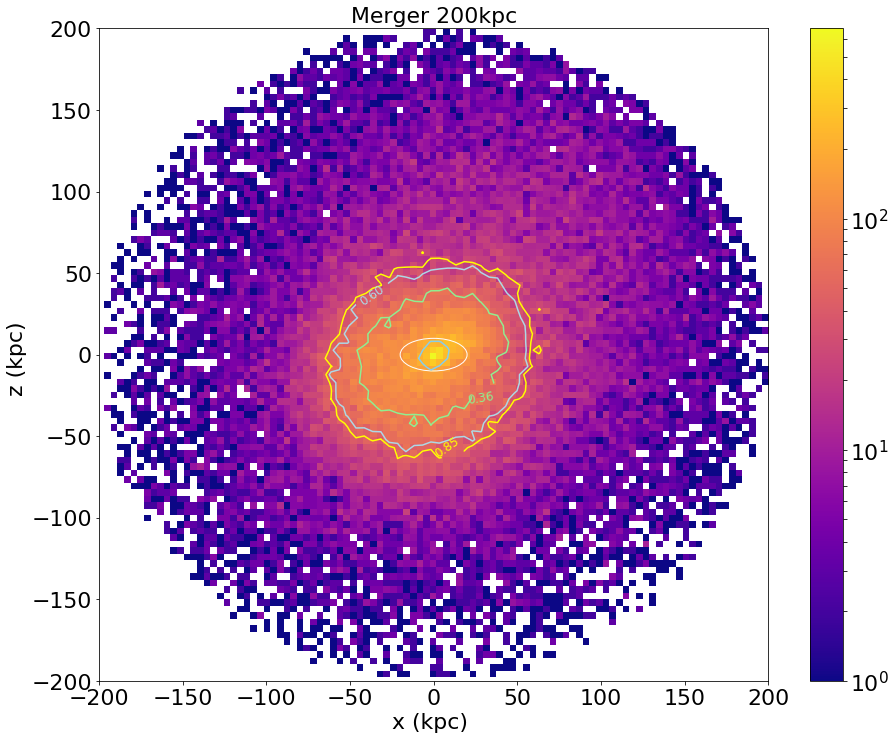

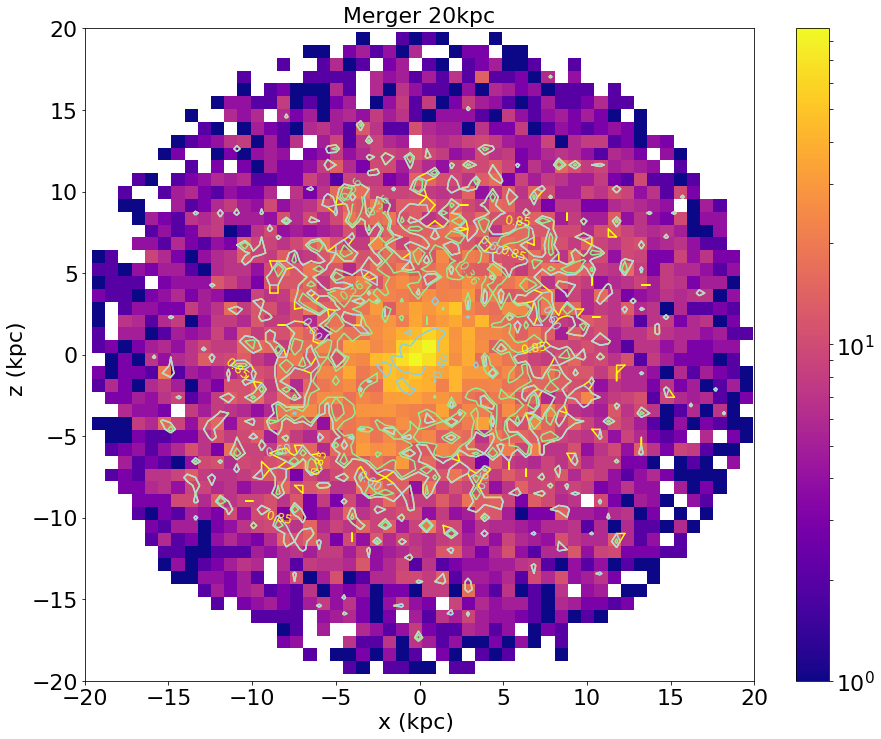

In [29]:
# MERGER 200kpc x-z

fig, ax= plt.subplots(figsize=(15,12))

# plot the particle density for Merger , 2D histogram
plt.hist2d(x_mw[index2_mw], z_mw[index2_mw], bins=100, norm=LogNorm(), cmap='plasma')
plt.colorbar() 

### plot elipse

x0, y0 = 0, 0
a, b = 20, 10
theta = Angle(0, 'deg')
e = Ellipse2D(amplitude=100., x_0=x0, y_0=y0, a=a, b=b,
              theta=theta.radian)
# y, x = np.mgrid[0:50, 0:50]
# fig, ax = plt.subplots(1, 1)
#ax.imshow(e(x, y), origin='lower', interpolation='none')
e2 = mpatches.Ellipse((x0, y0), 2*a, 2*b, theta.degree, edgecolor='white', facecolor = 'none')
ax.add_patch(e2)





# plot contours
density_contour(x_merger[index2_merger], z_merger[index2_merger], 80, 80, ax=ax, colors=['yellow', 'lightblue', 'lightgreen', 'skyblue', 'turquoise'])

# Add axis labels
ax.set_title("Merger 200kpc", fontsize=22)
plt.xlabel('x (kpc) ', fontsize=22)
plt.ylabel('z (kpc) ', fontsize=22)

#set axis limits
plt.ylim(-200,200)
plt.xlim(-200,200)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size




########### Merger 20 kpc x-z
fig, ax= plt.subplots(figsize=(15, 12))

# plot the particle density for Merger , 2D histogram
plt.hist2d(x_merger[index1_merger], z_merger[index1_merger], bins=50, norm=LogNorm(), cmap='plasma')
plt.colorbar() 




# plot contours
density_contour(x_merger[index1_merger], z_merger[index1_merger], 80, 80, ax=ax, colors=['yellow', 'lightblue', 'lightgreen', 'skyblue', 'turquoise'])

# Add axis labels
ax.set_title("Merger 20kpc", fontsize=22)
plt.xlabel('x (kpc) ', fontsize=22)
plt.ylabel('z (kpc) ', fontsize=22)

#set axis limits
plt.ylim(-20,20)
plt.xlim(-20,20)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

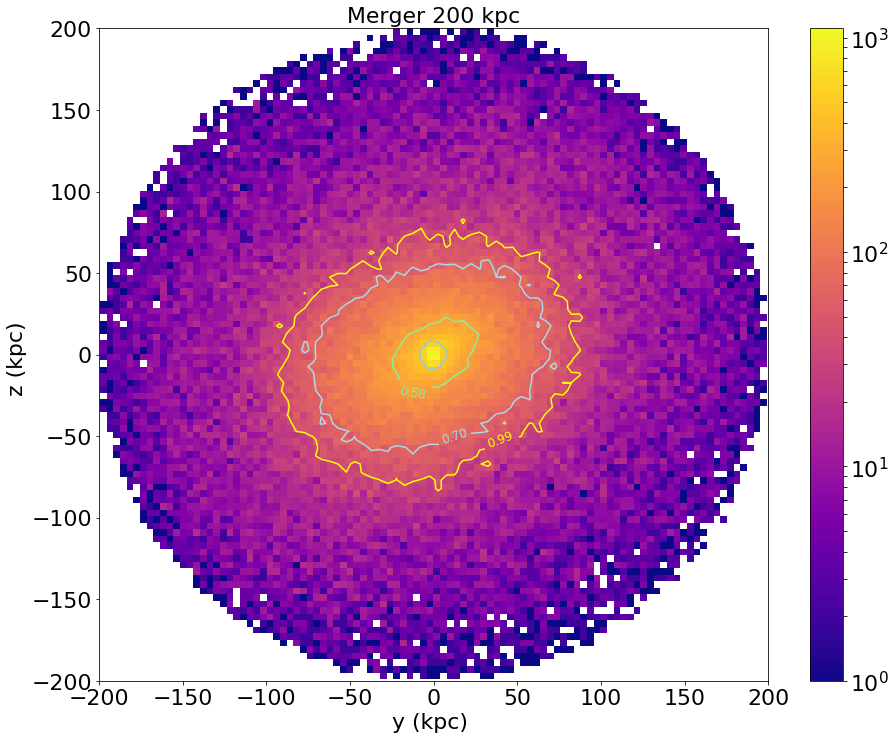

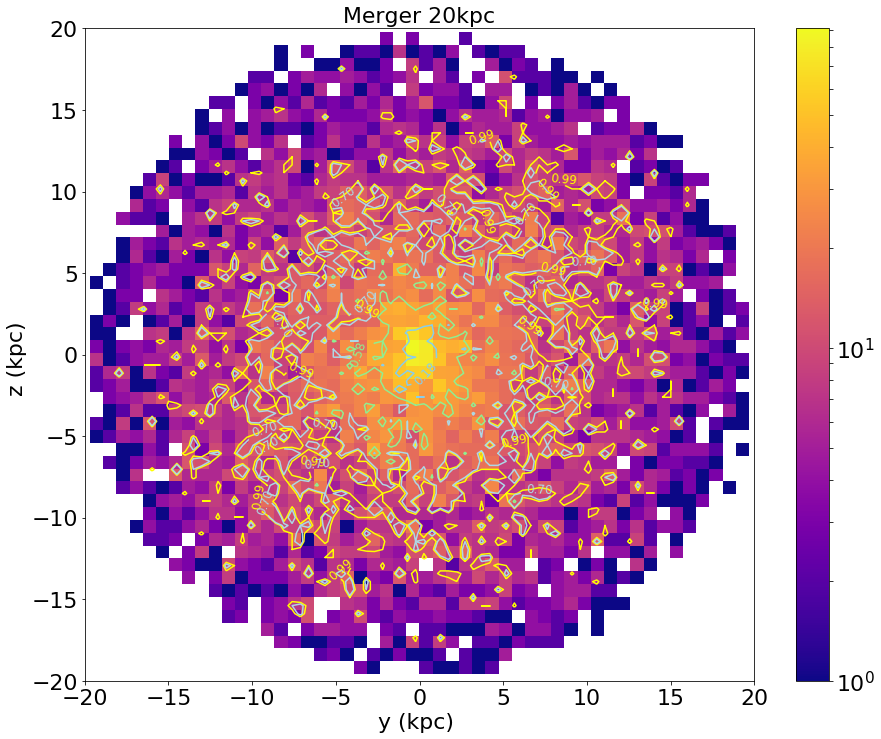

In [55]:
# MERGER 200kpc y-z

fig, ax= plt.subplots(figsize=(15,12))

# plot the particle density for Merger, 2D histogram
plt.hist2d(y_merger[index2_merger], z_merger[index2_merger], bins=100, norm=LogNorm(), cmap='plasma')

### plot elipse

plt.colorbar() 

# plot contours
density_contour(y_merger[index2_merger], z_merger[index2_merger], 80, 80, ax=ax, colors=['yellow', 'lightblue', 'lightgreen', 'skyblue', 'turquoise'])

# Add axis labels
ax.set_title("Merger 200 kpc", fontsize=22)
plt.xlabel('y (kpc) ', fontsize=22)
plt.ylabel('z (kpc) ', fontsize=22)

#set axis limits
plt.ylim(-200,200)
plt.xlim(-200,200)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size



# Merger 20kpc y-z
fig, ax= plt.subplots(figsize=(15, 12))

# plot the particle density for Merger , 2D histogram
plt.hist2d(y_merger[index1_merger], z_merger[index1_merger], bins=50, norm=LogNorm(), cmap='plasma')

### plot elipse

plt.colorbar() 

# plot contours
density_contour(y_merger[index1_merger], z_merger[index1_merger], 80, 80, ax=ax, colors=['yellow', 'lightblue', 'lightgreen', 'skyblue', 'turquoise'])

# Add axis labels
ax.set_title("Merger 20kpc", fontsize=22)
plt.xlabel('y (kpc) ', fontsize=22)
plt.ylabel('z (kpc) ', fontsize=22)

#set axis limits
plt.ylim(-20,20)
plt.xlim(-20,20)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

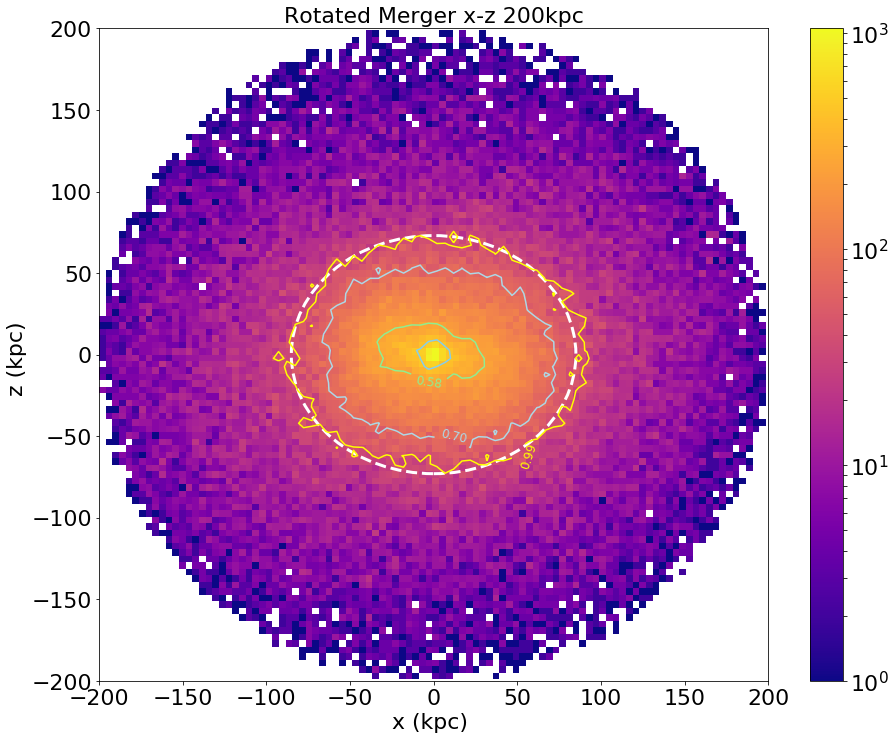

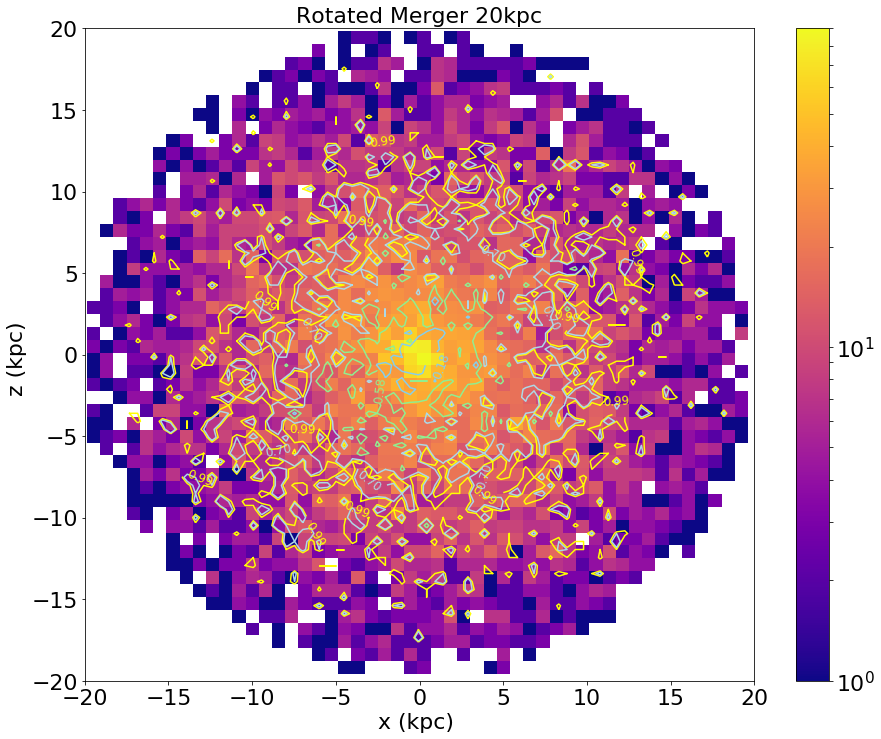

In [64]:
# Rotated MERGER 200kpc x-z

fig, ax= plt.subplots(figsize=(15,12))

# plot the particle density for rotated merger, 2D histogram
plt.hist2d(rmerger_new200[:,0], rmerger_new200[:,2], bins=100, norm=LogNorm(), cmap='plasma')
plt.colorbar()

### plot elipse
x0, y0 = 0, 0
a, b = 85, 73
theta = Angle(0, 'deg')
e = Ellipse2D(amplitude=100., x_0=x0, y_0=y0, a=a, b=b,
              theta=theta.radian)
# y, x = np.mgrid[0:50, 0:50]
# fig, ax = plt.subplots(1, 1)
#ax.imshow(e(x, y), origin='lower', interpolation='none')
e2 = mpatches.Ellipse((x0, y0), 2*a, 2*b, theta.degree, edgecolor='white', facecolor = 'none', linestyle='--', linewidth = 3)
ax.add_patch(e2)

 

# plot contours
density_contour(rmerger_new200[:,0], rmerger_new200[:,2], 80, 80, ax=ax, colors=['yellow', 'lightblue', 'lightgreen', 'skyblue', 'turquoise'])

# Add axis labels
ax.set_title("Rotated Merger x-z 200kpc", fontsize=22)
plt.xlabel('x (kpc) ', fontsize=22)
plt.ylabel('z (kpc) ', fontsize=22)

#set axis limits
plt.ylim(-200,200)
plt.xlim(-200,200)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


# Rotated Merger 20 kpc

# Merger Density x-z
fig, ax= plt.subplots(figsize=(15, 12))

# plot the particle density for rotated Merger , 2D histogram
plt.hist2d(rmerger_new20[:,0], rmerger_new20[:,2], bins=50, norm=LogNorm(), cmap='plasma')
plt.colorbar() 

### plot elipse




# plot contours
density_contour(x_merger[index1_merger], z_merger[index1_merger], 80, 80, ax=ax, colors=['yellow', 'lightblue', 'lightgreen', 'skyblue', 'turquoise'])

# Add axis labels
ax.set_title("Rotated Merger 20kpc", fontsize=22)
plt.xlabel('x (kpc) ', fontsize=22)
plt.ylabel('z (kpc) ', fontsize=22)

#set axis limits
plt.ylim(-20,20)
plt.xlim(-20,20)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

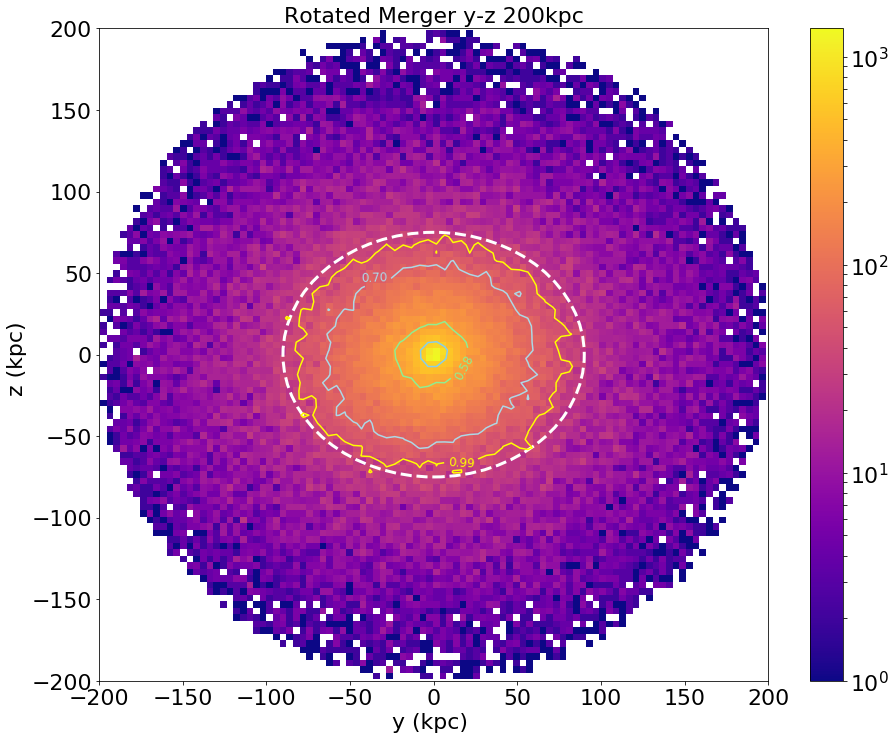

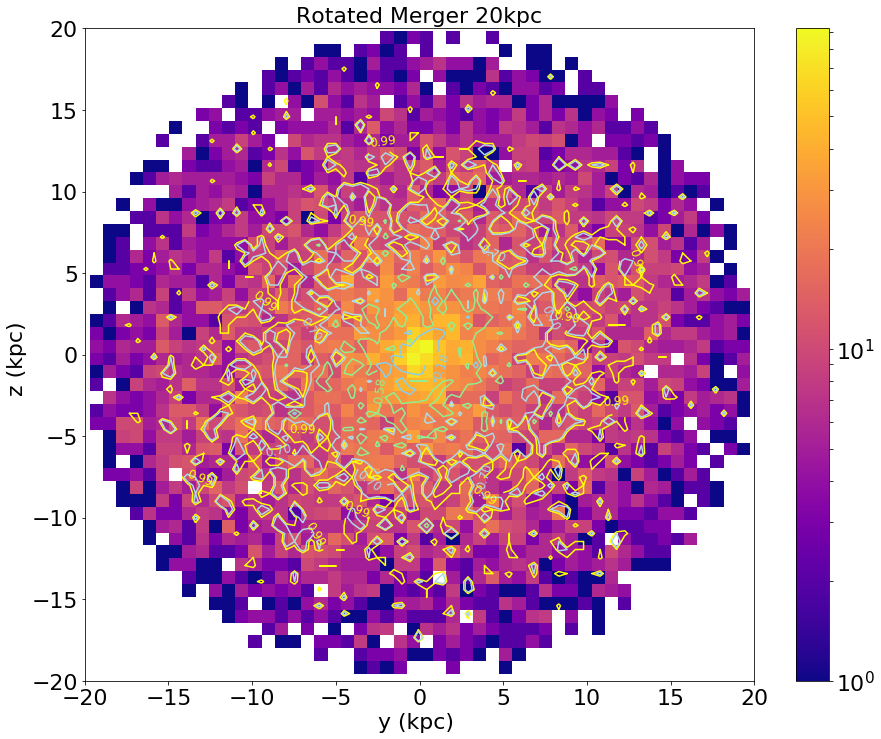

In [66]:
# Rotated MERGER 200kpc x-z

fig, ax= plt.subplots(figsize=(15,12))

# plot the particle density for rotated merger, 2D histogram
plt.hist2d(rmerger_new200[:,1], rmerger_new200[:,2], bins=100, norm=LogNorm(), cmap='plasma')
plt.colorbar() 

### plot elipse
x0, y0 = 0, 0
a, b = 90, 75
theta = Angle(0, 'deg')
e = Ellipse2D(amplitude=100., x_0=x0, y_0=y0, a=a, b=b,
              theta=theta.radian)
# y, x = np.mgrid[0:50, 0:50]
# fig, ax = plt.subplots(1, 1)
#ax.imshow(e(x, y), origin='lower', interpolation='none')
e2 = mpatches.Ellipse((x0, y0), 2*a, 2*b, theta.degree, edgecolor='white', facecolor = 'none', linestyle='--', linewidth = 3)
ax.add_patch(e2)


# plot contours
density_contour(rmerger_new200[:,1], rmerger_new200[:,2], 80, 80, ax=ax, colors=['yellow', 'lightblue', 'lightgreen', 'skyblue', 'turquoise'])

# Add axis labels
ax.set_title("Rotated Merger y-z 200kpc", fontsize=22)
plt.xlabel('y (kpc) ', fontsize=22)
plt.ylabel('z (kpc) ', fontsize=22)

#set axis limits
plt.ylim(-200,200)
plt.xlim(-200,200)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


# Rotated Merger 20 kpc

# Merger Density x-z
fig, ax= plt.subplots(figsize=(15, 12))

# plot the particle density for rotated Merger , 2D histogram
plt.hist2d(rmerger_new20[:,1], rmerger_new20[:,2], bins=50, norm=LogNorm(), cmap='plasma')
plt.colorbar()

### plot elipse


 

# plot contours
density_contour(x_merger[index1_merger], z_merger[index1_merger], 80, 80, ax=ax, colors=['yellow', 'lightblue', 'lightgreen', 'skyblue', 'turquoise'])

# Add axis labels
ax.set_title("Rotated Merger 20kpc", fontsize=22)
plt.xlabel('y (kpc) ', fontsize=22)
plt.ylabel('z (kpc) ', fontsize=22)

#set axis limits
plt.ylim(-20,20)
plt.xlim(-20,20)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

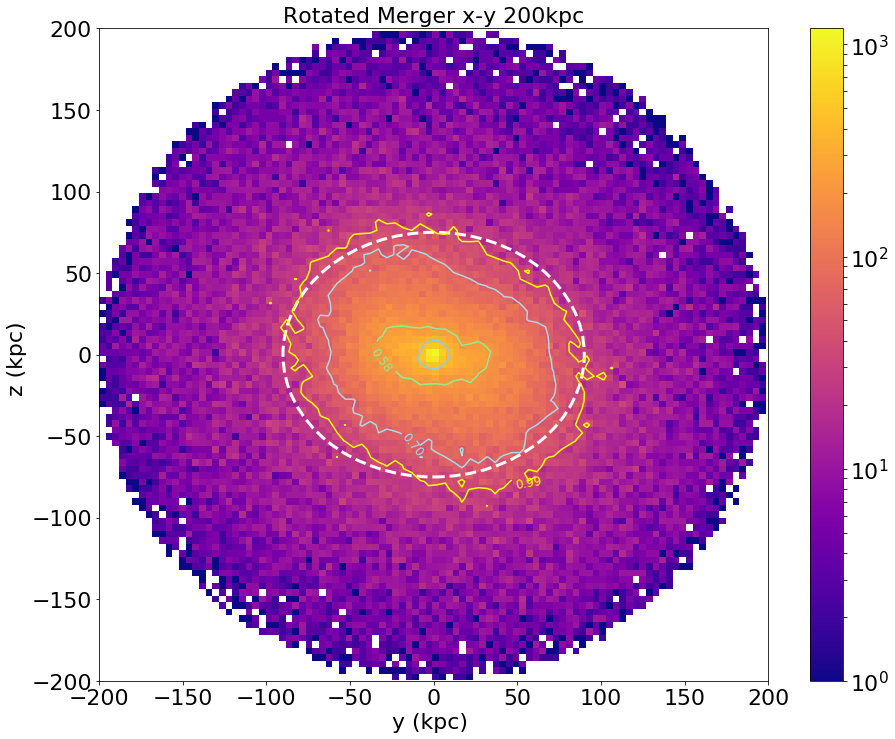

In [67]:
# Rotated MERGER 200kpc x-y

fig, ax= plt.subplots(figsize=(15,12))

# plot the particle density for rotated merger, 2D histogram
plt.hist2d(rmerger_new200[:,0], rmerger_new200[:,1], bins=100, norm=LogNorm(), cmap='plasma')
plt.colorbar() 

### plot elipse
x0, y0 = 0, 0
a, b = 90, 75
theta = Angle(0, 'deg')
e = Ellipse2D(amplitude=100., x_0=x0, y_0=y0, a=a, b=b,
              theta=theta.radian)
# y, x = np.mgrid[0:50, 0:50]
# fig, ax = plt.subplots(1, 1)
#ax.imshow(e(x, y), origin='lower', interpolation='none')
e2 = mpatches.Ellipse((x0, y0), 2*a, 2*b, theta.degree, edgecolor='white', facecolor = 'none', linestyle='--', linewidth = 3)
ax.add_patch(e2)


# plot contours
density_contour(rmerger_new200[:,0], rmerger_new200[:,1], 80, 80, ax=ax, colors=['yellow', 'lightblue', 'lightgreen', 'skyblue', 'turquoise'])

# Add axis labels
ax.set_title("Rotated Merger x-y 200kpc", fontsize=22)
plt.xlabel('y (kpc) ', fontsize=22)
plt.ylabel('z (kpc) ', fontsize=22)

#set axis limits
plt.ylim(-200,200)
plt.xlim(-200,200)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

In [ ]:


x0, y0 = 25, 25
a, b = 20, 10
theta = Angle(0, 'deg')
e = Ellipse2D(amplitude=100., x_0=x0, y_0=y0, a=a, b=b,
              theta=theta.radian)
y, x = np.mgrid[0:50, 0:50]
fig, ax = plt.subplots(1, 1)
ax.imshow(e(x, y), origin='lower', interpolation='none')
e2 = mpatches.Ellipse((x0, y0), 2*a, 2*b, theta.degree, edgecolor='red')
                      
ax.add_patch(e2)
plt.show()